# Generating plots with heatmaps for interpretability

First we load the model from hugginface.

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
from IPython.display import Image
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
from transformers import pipeline

# loading FART  models from kaggle 
model_name = "FartLabs/Model_C"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer_name = "FartLabs/Model_C"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

pipe = pipeline("text-classification", model=model_name)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


## Util functions

In [5]:
def get_taste_from_smiles(smiles): 
    """
    Predicts the taste of a compound from its SMILES string.

    Parameters:
    - smiles (str): SMILES string of the compound.

    Returns:
    - str: Predicted taste and confidence score in the format "TASTE score: X.XX".
    """
    # Get model prediction from SMILES input
    output = pipe(smiles)

    # Taste labels corresponding to model output
    taste_labels = ['BITTER', 'SOUR', 'SWEET', 'UMAMI', 'UNDEFINED']

    # Extract label index and confidence score
    label_info = output[0]
    label_index = int(label_info['label'].split('_')[1])  # Numeric label index
    score = label_info['score']

    # Map label to taste and format result
    new_label = taste_labels[label_index]
    title_string = f"{new_label} score: {score:.2f}"

    return title_string

def calculate_aspect_ratio(molecule, base_size):
    """
    Calculates canvas dimensions based on the molecule's aspect ratio.

    Parameters:
    - molecule (Mol): RDKit molecule object.
    - base_size (int): Default canvas size, usually 400.

    Returns:
    - (int, int): Width and height for the canvas.
    """
    # Get atom positions and calculate width, height, and aspect ratio
    conf = molecule.GetConformer()
    atom_positions = [conf.GetAtomPosition(i) for i in range(molecule.GetNumAtoms())]
    x_coords = [pos.x for pos in atom_positions]
    y_coords = [pos.y for pos in atom_positions]
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    aspect_ratio = width / height if height > 0 else 1

    # Adjust canvas dimensions based on aspect ratio
    canvas_width = max(base_size, int(base_size * aspect_ratio)) if aspect_ratio > 1 else base_size
    canvas_height = max(base_size, int(base_size / aspect_ratio)) if aspect_ratio < 1 else base_size

    return canvas_width, canvas_height

def visualize_gradients(smiles, bw=True, padding=0.05):
    """
    Visualizes atom-wise importance scores for a molecule as a similarity map.

    Parameters:
    - smiles (str): SMILES string of the molecule.
    - bw (bool): If True, renders in black and white (default True).
    - padding (float): Padding around the molecule in the image.

    Returns:
    - Image: Similarity map of atom importance.
    """
    # Print predicted taste for the molecule
    print(get_taste_from_smiles(smiles))

    # Convert SMILES to RDKit molecule and compute 2D coordinates
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Set up canvas size based on aspect ratio
    base_size = 400
    width, height = calculate_aspect_ratio(molecule, base_size)
    d = Draw.MolDraw2DCairo(width, height)
    d.drawOptions().padding = padding
    
    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Get atom importance scores and map to molecule
    token_importance = cls_explainer(smiles)
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    atom_importance = atom_importance[:molecule.GetNumAtoms()]
    
    # Generate similarity map from atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)
    
    # Convert drawing to image and display
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img


In [6]:
def save_high_quality_png(smiles, title, bw=True, padding=0.05):
    """
    Generates a high-quality PNG of atom-wise gradients or importance scores for a molecule.

    Parameters:
    - smiles (str): The SMILES string of the molecule to visualize.
    - token_importance (list): List of importance scores for each atom.
    - bw (bool): If True, renders the molecule in black and white.
    - padding (float): Padding for molecule drawing.
    - output_file (str): Path to save the high-quality PNG file.

    Returns:
    - None
    """
    
    # Convert SMILES string to RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    Chem.rdDepictor.Compute2DCoords(molecule)
    
    # Get token importance scores and map to atoms
    token_importance = cls_explainer(smiles)
    atom_importance = [c[1] for c in token_importance if c[0].isalpha()]
    num_atoms = molecule.GetNumAtoms()
    atom_importance = atom_importance[:num_atoms]
    
    # Set a large canvas size for high resolution
    d = Draw.MolDraw2DCairo(1500, 1500)

    dopts = d.drawOptions()
    dopts.padding = padding    
    dopts.maxFontSize = 2000
    dopts.bondLineWidth = 5

    # Optionally set black and white palette
    if bw:
        d.drawOptions().useBWAtomPalette()
    
    # Generate and display a similarity map based on atom importance scores
    SimilarityMaps.GetSimilarityMapFromWeights(molecule, atom_importance, draw2d=d)

    # Draw molecule with color highlights
    d.FinishDrawing()
    
    # Save to PNG file with high quality
    with open(f"{title}.png", "wb") as png_file:
        png_file.write(d.GetDrawingText())
    
    print(f"High-quality PNG file saved as {title}.png")
    d.FinishDrawing()
    png_data = d.GetDrawingText()
    img = Image(data=png_data)
    return img


## Example 

SOUR score: 0.66


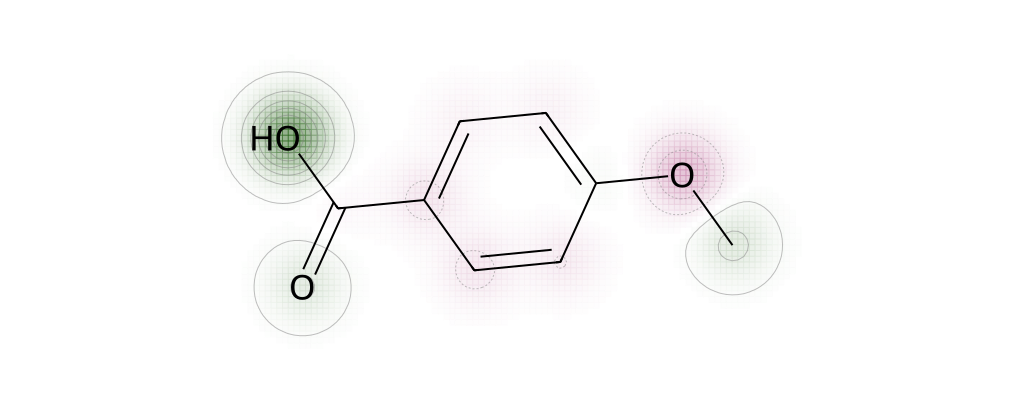

In [8]:
benzoic_acid = "O=C(O)c1ccc(OC)cc1"

visualize_gradients(benzoic_acid, bw=True, padding=0.1) # padding gives some distance to the borders of the canvas

There is also a pre-implemented function to get a larger PNG output for better output. Unfortunately, SimilarityMap is incompatible with vectorized formats such as SVG. 

High-quality PNG file saved as anisic_acid.png


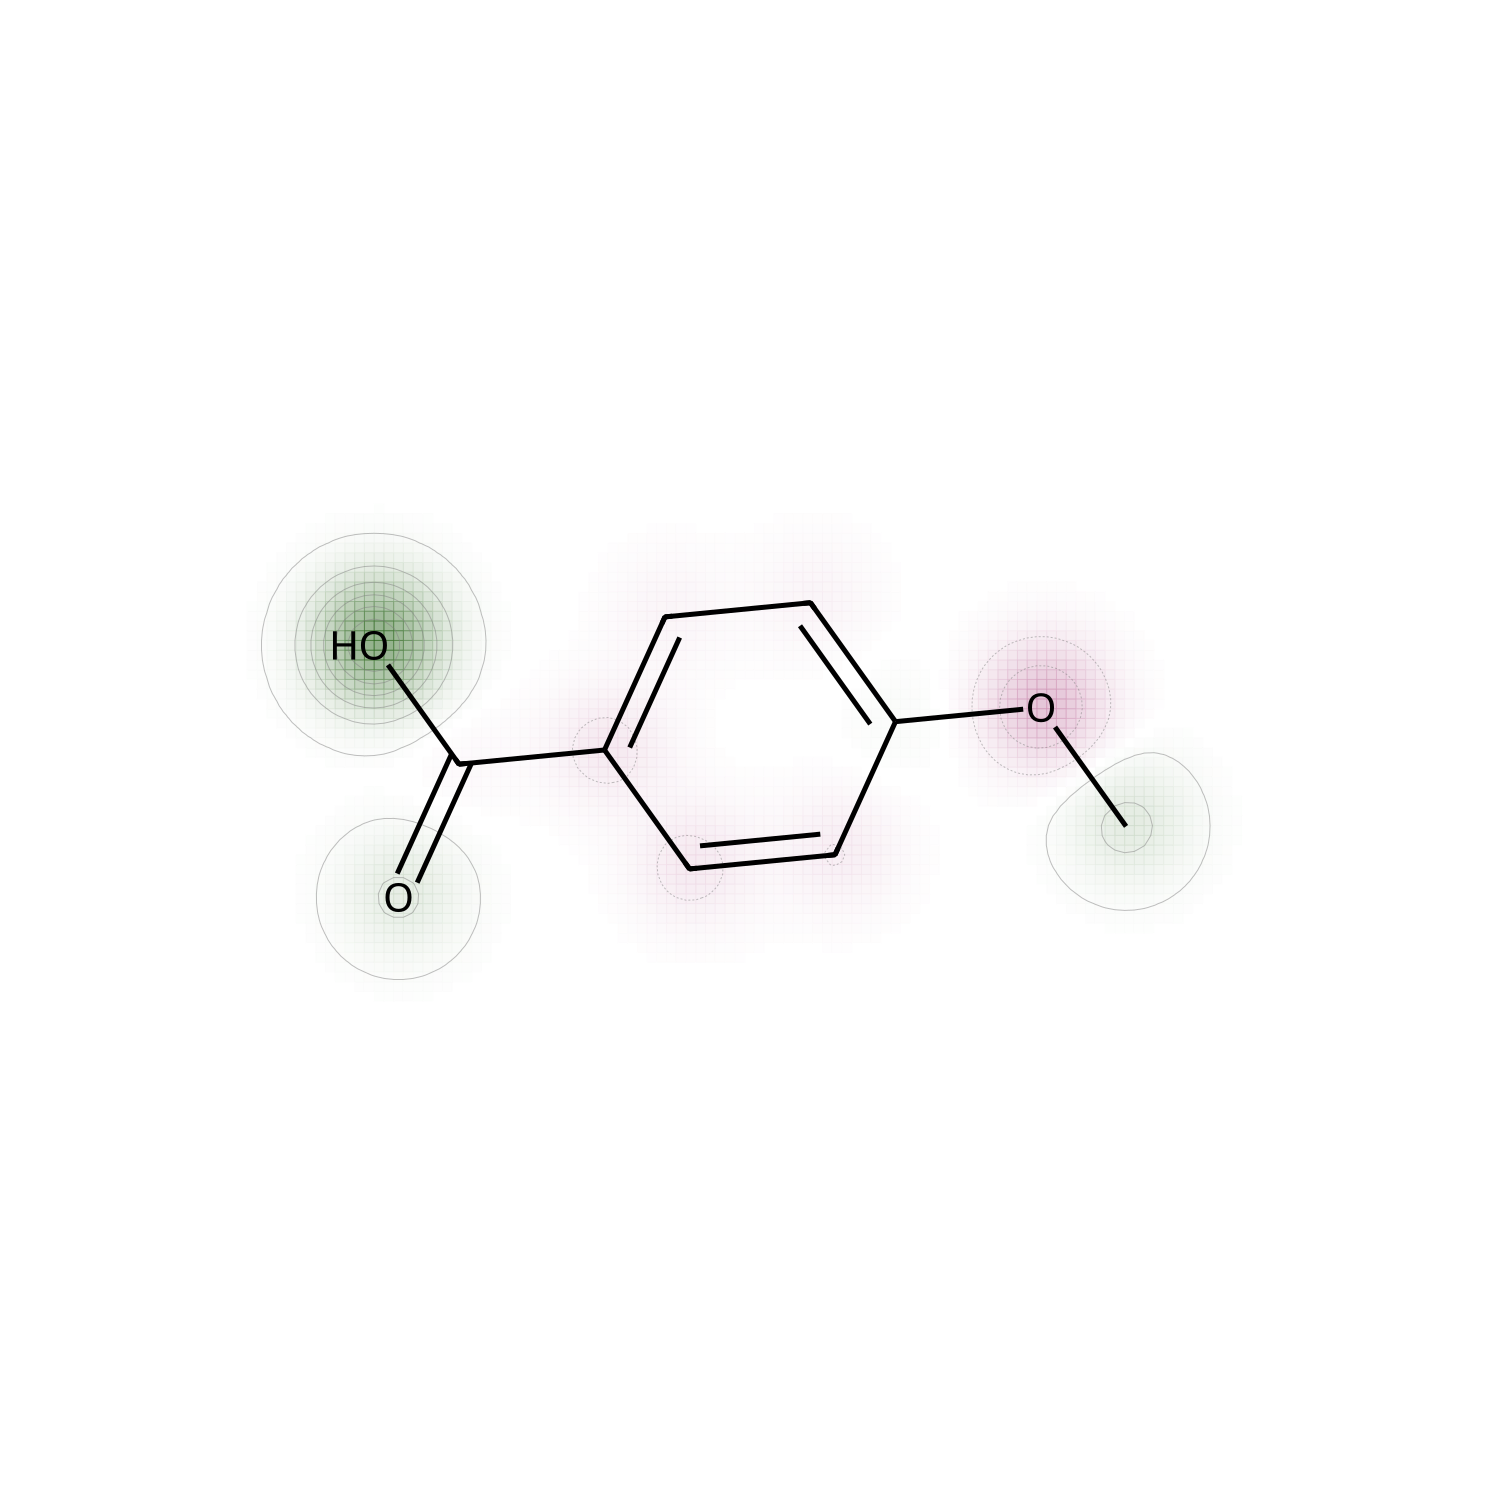

In [10]:
save_high_quality_png(benzoic_acid, title="anisic_acid", bw=True, padding=0.1)